In [1]:
# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# read raw data (expression data) to pandas df
pre_adata = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190115_big_counts.txt', 
                      index_col=[0])
                .rename(columns = {'gene':'gene_name'})
                .set_index('gene_name'))
cell_names = ['_'.join(x.split('_')[:2]) for x in pre_adata.columns]
pre_adata.columns = cell_names

# metadata:
## download lastest from google drive and push to s3
meta_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190115_mel_metadata.csv')
meta_df = meta_df.drop(['seq_run', 
                        'GWAS_consent', 
                        'sort_info_exported',
                       'sort_date',
                       'plate_order',
                       'sample_number',
                       'plate_status'], axis = 1)
possible_wells = [f'{y}{x}'for y in string.ascii_uppercase[:-10] for x in range(1,25)]
all_wells_df = pd.DataFrame()
for plate in meta_df.plate_barcode:
    well_df = pd.DataFrame({'well':possible_wells})
    well_df['plate_barcode'] = plate
    all_wells_df = pd.concat([all_wells_df, well_df], axis = 0)
    
meta_df = pd.merge(meta_df, all_wells_df, 'left', 'plate_barcode')
meta_df['cell_name'] = [f'{x}_{y}' for x,y in zip(meta_df.well, meta_df.plate_barcode)]

# add bsc data:
bsc = pd.read_csv('s3://daniel.le-work/MEL_project/DL20181106_bsc_metadata.csv')
merged_anno = pd.merge(meta_df,bsc,'left',['well','plate_barcode'])

# filter merged annotations
merged_anno = merged_anno[[x in cell_names for x in merged_anno.cell_name]]
merged_anno = pd.merge(pd.DataFrame({'cell_name':cell_names}), merged_anno, 'left', 'cell_name')
merged_anno = merged_anno.set_index('cell_name')

# markers
markers = ['PMEL','KRT1','KRT5','KRT10','TYR','MITF']

scanpy version: 1.3.3


In [5]:

raw_adata = create_adata(pre_adata)
raw_adata.var['ribo'] = raw_adata.var_names.str.startswith(('RPL','RPS'))
raw_adata.var['ercc'] = np.array([True if 'ERCC' in x else False for x in raw_adata.var_names.tolist()])
sc.pp.calculate_qc_metrics(raw_adata, feature_controls=['ribo','ercc'], inplace=True)
anno_dict = {'age':'age',
             'age_bin':'age_bin',
             'plate_barcode':'plate',
             'general_location':'general_location',
             'anatomical_location':'anatomical_location',
             'race':'race',
             'sex':'sex',
             'sample_color':'color',
             'patient_id':'patient',
             'bsc_a':'bsc'}
append_anno(raw_adata, merged_anno, anno_dict)
append_markers(raw_adata, gene_markers=markers)
technical_filters(raw_adata)
raw_adata = remove_ercc(raw_adata) 
raw_adata.raw = sc.pp.log1p(raw_adata, copy=True) # freeze raw state

Ingest raw data...
	Cells: 8051, Genes: 26577
Append annotations...
	Cells: 8051, Genes: 26577
Append marker gene expresssion...
Remove low-quality cells/genes...
	Initial:
	Cells: 8051, Genes: 26577
	Result:
	Cells: 5911, Genes: 23870
Remove ERCC genes...
Filtered genes: 87
	Cells: 5911, Genes: 23783


In [6]:
# create coarse age_groups and add ordered categories
reclass_dict = {'FET_12WK':'FET_12WK',
                 'NEO':'NEO',
                 '20_29':'20_49',
                 '30_39':'20_49',
                 '40_49':'20_49',
                 '50_59':'50_89',
                 '60_69':'50_89',
                 '80_89':'50_89'}
raw_adata.obs['age_group'] = (raw_adata
                                  .obs['age_bin']
                                  .map(reclass_dict))

ordered_groups_age_group = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
ordered_groups_age_bin = ['FET_12WK',
                 'NEO',
                 '20_29',
                 '30_39',
                 '40_49',
                 '50_59',
                 '60_69',
                 '80_89']

for class_name in ['age_bin','age_group']:
    raw_adata.obs[class_name] = (raw_adata
                                      .obs[class_name]
                                      .astype(str)
                                      .astype(CategoricalDtype(eval(f'ordered_groups_{class_name}'), ordered=True)))
    

Process expression data...
	Initial:
	Cells: 5911, Genes: 23783
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13414
	Result:
	Cells: 5911, Genes: 10369
Principle component analysis...


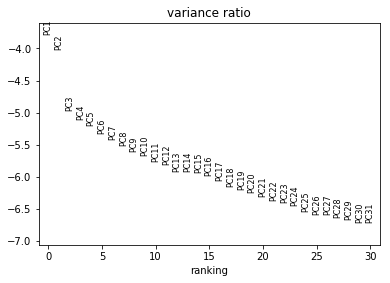

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


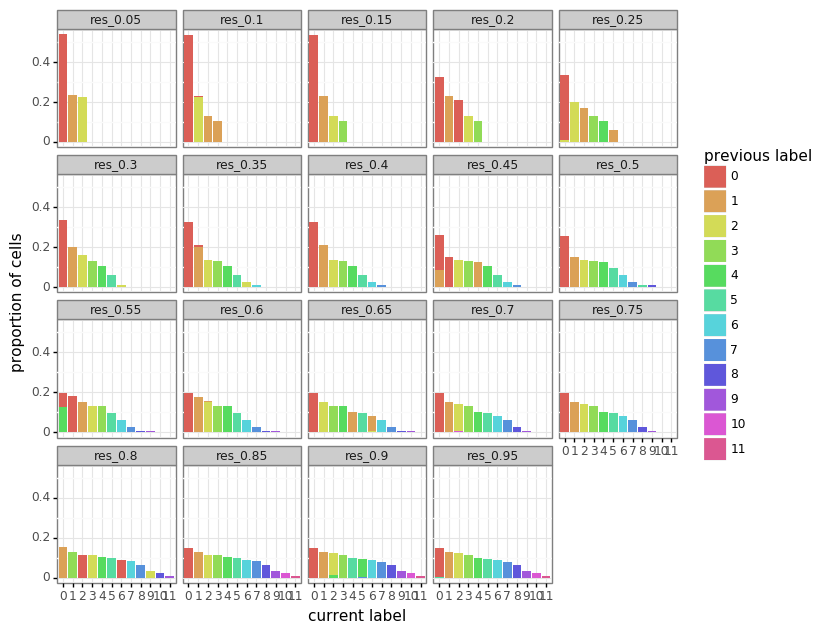

<ggplot: (8733427298259)>


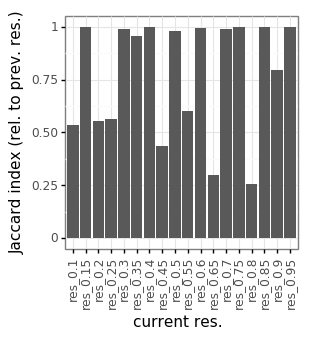

<ggplot: (8733432872368)>
resolution(res): 0.25


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical


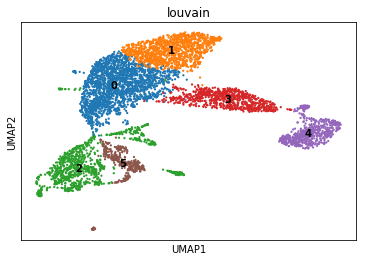

In [13]:
full_adata = process_adata(raw_adata)
pca_adata(full_adata, num_pcs=30)
umap_adata(full_adata, res=0.25)

In [5]:
# classify in raw adata
input_adata = full_adata

MEL_int = [0,1,3,4]
KRT_int = [x for x in range(len(input_adata.obs['louvain'].cat.categories)) if x not in MEL_int]
type_dict = {'KRT':[str(x) for x in KRT_int],
             'MEL':[str(x) for x in MEL_int]}
    
classify_type(raw_adata, input_adata, 'louvain', type_dict, 'class_1')

key = class_1, value = MEL, matched = 4561
	Cells: 4561, Genes: 23783
Process expression data...
	Initial:
	Cells: 4561, Genes: 23783
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13610
	Result:
	Cells: 4561, Genes: 10173
Principle component analysis...


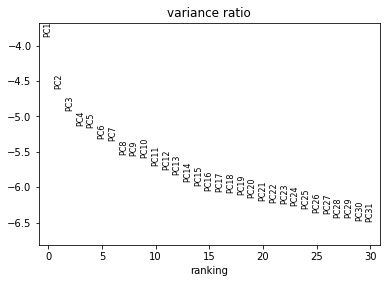

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


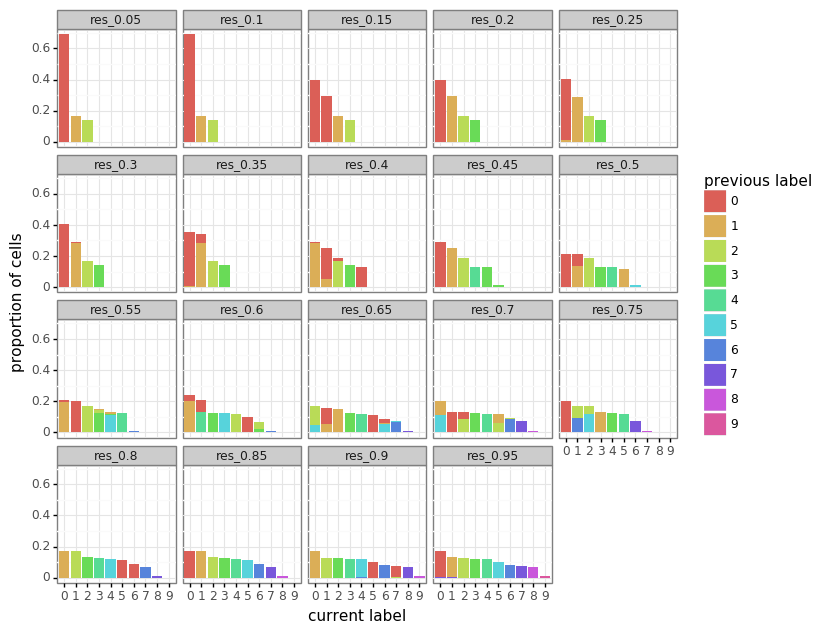

<ggplot: (8766759903089)>


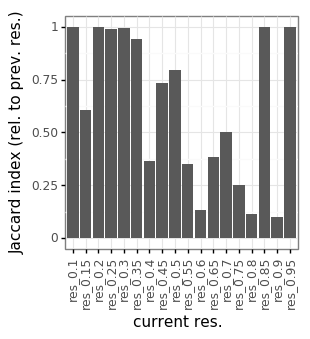

<ggplot: (8766761443518)>
resolution(res): 0.15


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical


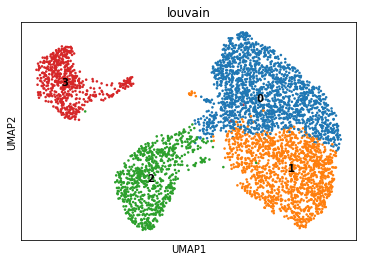

In [6]:
# MEL only

feature_dict = {'class_1':['MEL']}
adata_subset1 = subset_adata_v3(raw_adata,feature_dict)
adata_subset1 = process_adata(adata_subset1)
pca_adata(adata_subset1, num_pcs=30)
umap_adata(adata_subset1, res=0.15)

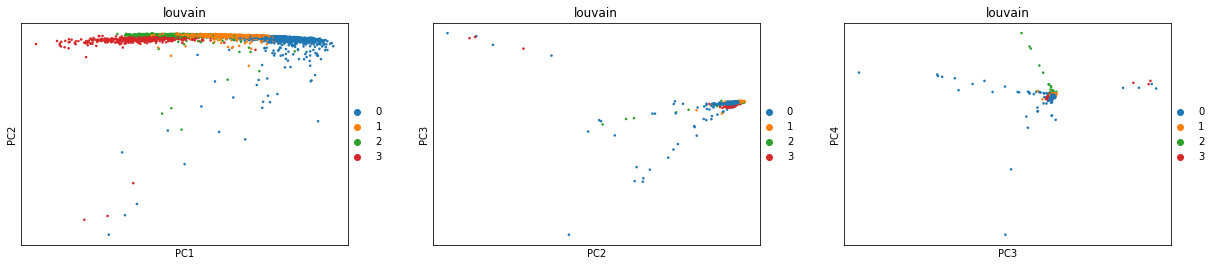

Filtered cells:  278


... storing 'outliers' as categorical


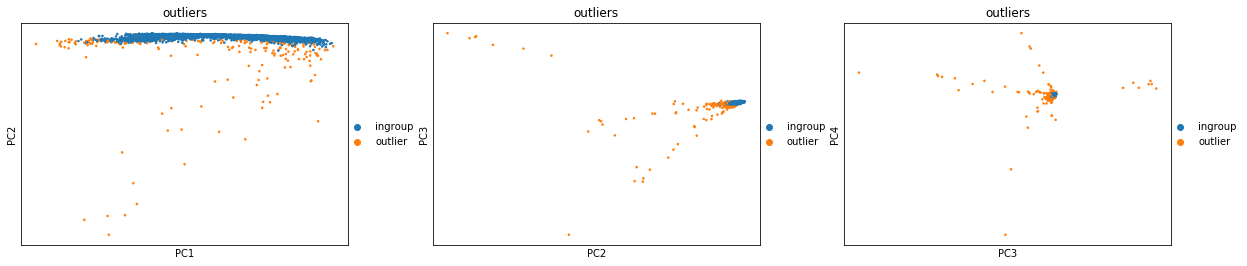

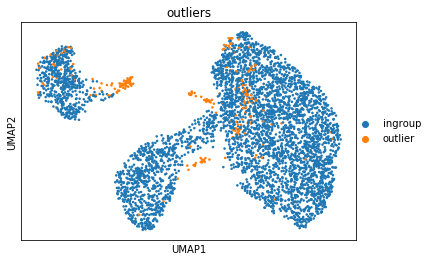

... storing 'outliers' as categorical


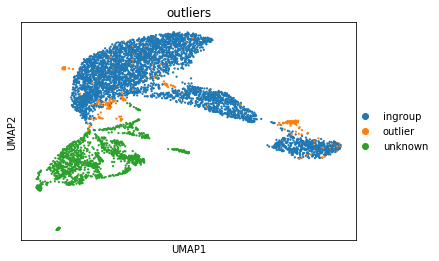

In [7]:
# initial PC coordinates
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(adata_subset1.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
#     print(len(set(omit_names)))
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=5

    bool_idx = [True if ((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) else False for x in df[pc]]
    filtered = df[bool_idx]
#     print('Filtered cells: ', len(df)-len(filtered))
    
    omit_names = omit_names + adata_subset1.obs[[not x for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))

# check where the outliers lie in original projection
input_adata = adata_subset1
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')

# outliers on all-cells projection
input_adata = adata_subset1

type_dict = {'ingroup':['ingroup'],
             'outlier':['outlier']}
    
classify_type(full_adata, input_adata, 'outliers', type_dict, 'outliers')

sc.pl.umap(full_adata, color=['outliers'])

In [ ]:
# classify in raw adata
input_adata = adata_subset1

type_dict = {'in':['ingroup'],
             'out':['outlier']}
    
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'class_2')

feature_dict = {'class_2':['in']}
adata_subset2 = subset_adata_v3(raw_adata,feature_dict)
adata_subset2 = process_adata(adata_subset2)
pca_adata(adata_subset2, num_pcs=10)
umap_adata(adata_subset2, res=0.35)

In [ ]:
# calculate txn noise
input_adata = adata_subset2
groupby = ['patient','anatomical_location']
features_df = (input_adata.obs.loc[:,groupby]
               .drop_duplicates()
               .reset_index()
               .drop('index', axis = 1))

noise_df = pd.DataFrame()
for row in range(len(features_df)):
    feature_slice = pd.DataFrame(features_df.iloc[row,:]).T
    filtered_adata = input_adata
    noise_group = []
    for col in feature_slice.columns:
        feature_match = feature_slice[col].values[0]
        filtered_adata = filtered_adata[filtered_adata.obs[col] == feature_match]
        noise_group.append(feature_match)

    cell_list = filtered_adata.obs.index.tolist()
    noise_slice = txn_noise_spearman(cell_list, pre_adata)
    noise_slice['noise_group'] = '_'.join(noise_group)
    noise_df = noise_df.append(noise_slice)

# update adata
ordered_noise = pd.merge(pd.DataFrame({'cell':adata_subset2.obs.index}), noise_df, 'left', 'cell')
adata_subset2.obs['agg_noise'] = ordered_noise.noise.values
adata_subset2.obs['noise_group'] = ordered_noise.noise_group.values
    

In [ ]:
# krt only re-cluster
feature_dict = {'class_1':['KRT']}
adata_subset1_KRT = subset_adata_v3(raw_adata,feature_dict)
adata_subset1_KRT = process_adata(adata_subset1_KRT)
pca_adata(adata_subset1_KRT, num_pcs=10)
umap_adata(adata_subset1_KRT, res=0.2)

In [ ]:
# pickle adatas
for objname in ['full_adata','adata_subset1','adata_subset2','pre_adata','adata_subset1_KRT']:
    pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
    syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
    subprocess.run(syscmd.split(' '))